# 1-  Comparison 1: Communication

## 1.1 - Sugarscape environment without communication

### 1.1.1 - Single Run With Rendering

pygame 2.1.3 (SDL 2.0.22, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


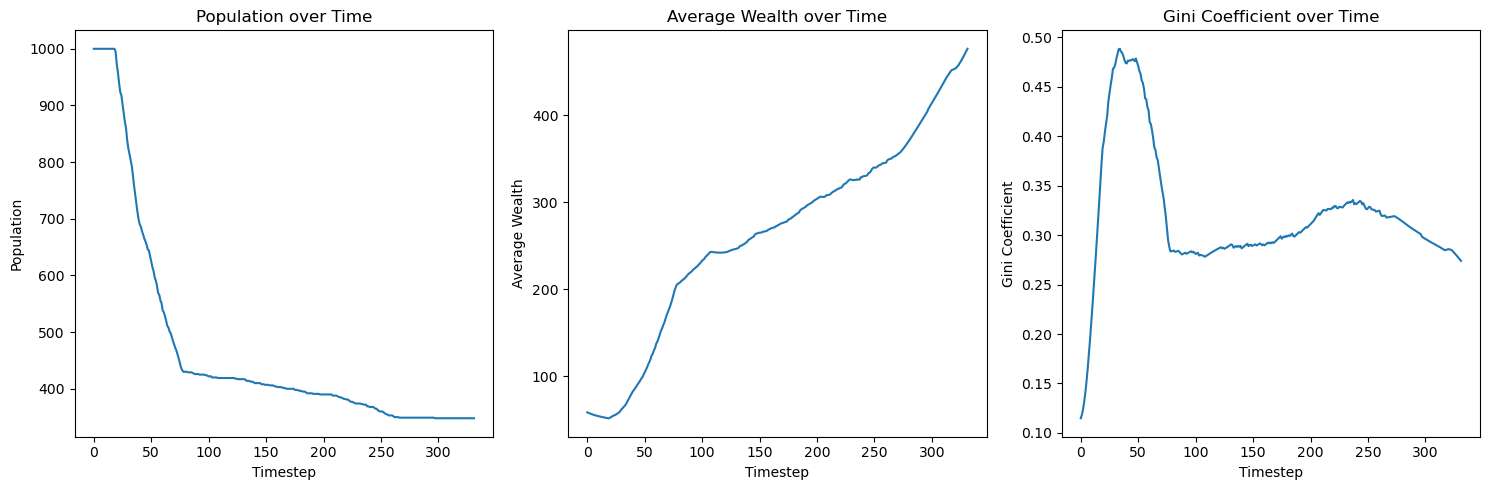

In [1]:
import random
import numpy as np
import pygame
import matplotlib.pyplot as plt

class SugarscapeEnvironment:
    def __init__(self, width, height, num_agents, cell_size=15, show_sugar_levels=True, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.seed = seed

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100)
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        pygame.init()
        self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
        pygame.display.set_caption("Sugarscape Simulation - Limited Vision")
        self.clock = pygame.time.Clock()

        # Initialize font for rendering text
        self.font = pygame.font.Font(None, 10)  # You may need to adjust the font size

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x, y = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x - center['x']) ** 2 + (y - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        # Round sugar levels to nearest integer
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id, 'x': x, 'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1,3),
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']
        adjacent_cells = self.get_adjacent_cells(x, y)

        best_cell = None
        best_sugar = -1

        for cell_x, cell_y in adjacent_cells:
            if (cell_x, cell_y) not in self.agent_positions:
                sugar_amount = self.sugar[cell_y, cell_x]
                if sugar_amount > best_sugar:
                    best_sugar = sugar_amount
                    best_cell = (cell_x, cell_y)

        if best_cell and best_sugar > 0:
            self.agent_positions.remove((agent['x'], agent['y']))
            agent['x'], agent['y'] = best_cell
            self.agent_positions.add((agent['x'], agent['y']))
        else:
            # Move randomly if no sugar is visible
            available_cells = [cell for cell in adjacent_cells if cell not in self.agent_positions]
            if available_cells:
                new_x, new_y = random.choice(available_cells)
                self.agent_positions.remove((agent['x'], agent['y']))
                agent['x'], agent['y'] = new_x, new_y
                self.agent_positions.add((agent['x'], agent['y']))
            # If no available cells, the agent stays put

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                # Render sugar quantity as text if show_sugar_levels is True
                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            self.clock.tick(50)

        self.plot_results()
        pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Example usage with a fixed seed for reproducibility
if __name__ == "__main__":
    SEED = 23
    env = SugarscapeEnvironment(width=50, height=50, num_agents=1000, cell_size=10, show_sugar_levels=False, seed=SEED)
    env.run_simulation(max_timesteps=1000)


### 1.1.2 - Multiple Runs With No Rendering

pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Starting baseline (Non-Communicative) simulations...
Running non-communicative simulation 1/20 with seed 0...
Running non-communicative simulation 2/20 with seed 1...
Running non-communicative simulation 3/20 with seed 2...
Running non-communicative simulation 4/20 with seed 3...
Running non-communicative simulation 5/20 with seed 4...
Running non-communicative simulation 6/20 with seed 5...
Running non-communicative simulation 7/20 with seed 6...
Running non-communicative simulation 8/20 with seed 7...
Running non-communicative simulation 9/20 with seed 8...
Running non-communicative simulation 10/20 with seed 9...
Running non-communicative simulation 11/20 with seed 10...
Running non-communicative simulation 12/20 with seed 11...
Running non-communicative simulation 13/20 with seed 12...
Running non-communicative simulation 14/20 with seed 13...
Running non-communicative s

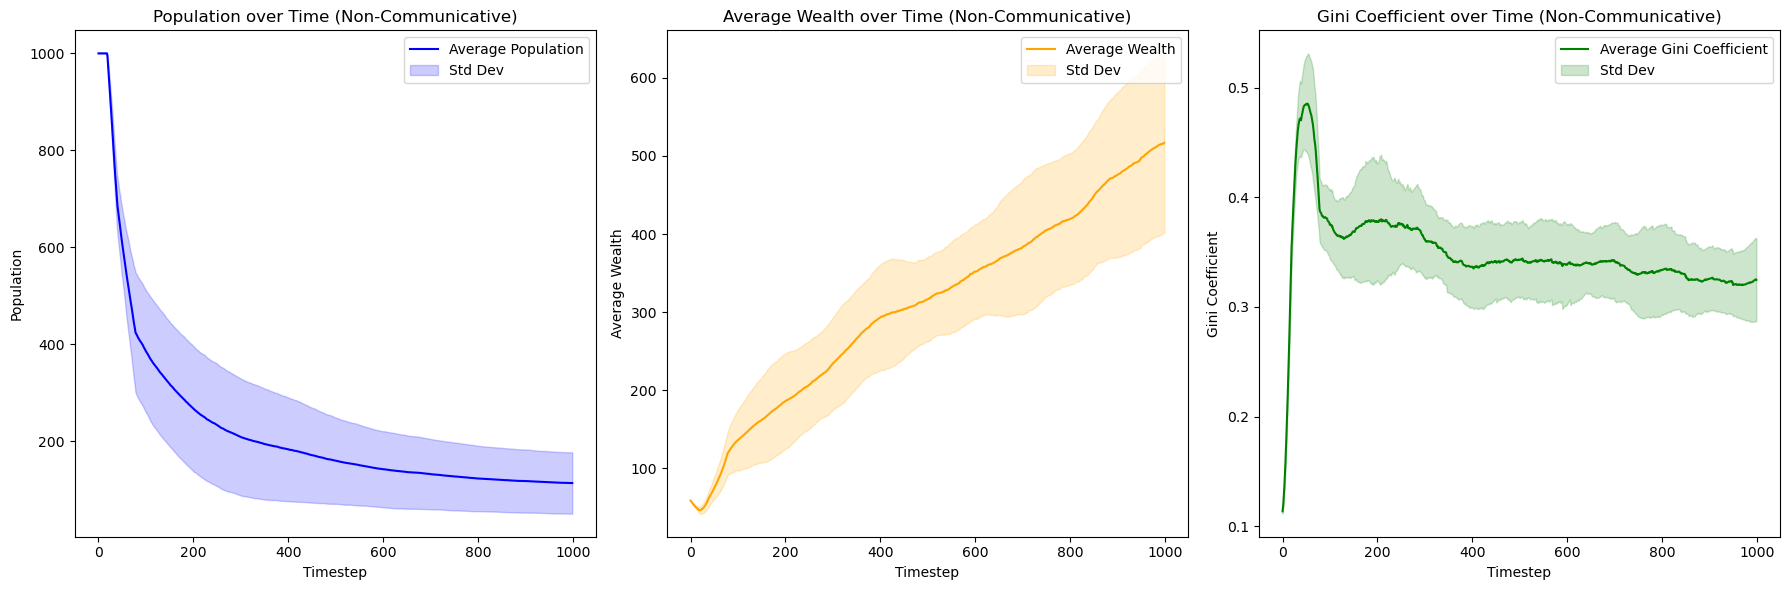


Non-Communicative simulations completed and results saved.


In [1]:
# non_communicative_model.py

import random
import numpy as np
import pygame
import matplotlib.pyplot as plt

class SugarscapeEnvironmentNonCommunicative:
    def __init__(self, width, height, num_agents, cell_size=15, show_sugar_levels=True, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'exploration_probability': 0.1  # Added exploration probability
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Non-Communicative")
            self.clock = pygame.time.Clock()

            # Initialize font for rendering text
            self.font = pygame.font.Font(None, 10)  # You may need to adjust the font size

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        # Round sugar levels to nearest integer
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id, 'x': x, 'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1,3),
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def move_agent_probabilistic_exploration(self, agent):
        x, y = agent['x'], agent['y']
        adjacent_cells = self.get_adjacent_cells(x, y)

        # Filter out occupied cells
        available_cells = [cell for cell in adjacent_cells if cell not in self.agent_positions]

        if not available_cells:
            return  # No move possible

        epsilon = self.params['exploration_probability']
        if random.random() < epsilon:
            # Exploration: choose a random available cell
            chosen_cell = random.choice(available_cells)
        else:
            # Exploitation: choose based on sugar availability
            weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_cells]  # +1 to avoid zero weights
            total_weight = sum(weights)
            probabilities = [weight / total_weight for weight in weights]
            chosen_cell = random.choices(available_cells, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_cell
        self.agent_positions.add(chosen_cell)

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents using probabilistic movement
        for agent in self.agents:
            self.move_agent_probabilistic_exploration(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                # Render sugar quantity as text if show_sugar_levels is True
                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(50)

        if self.visualize:
            self.plot_results()
            pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Function to run multiple simulations and collect averaged results
def run_multiple_simulations_non_communicative(num_runs=20, width=50, height=50, num_agents=1000,
                                               cell_size=10, max_timesteps=1000):
    population_histories = []
    average_wealth_histories = []
    gini_coefficient_histories = []

    for run in range(num_runs):
        seed = run  # Different seed for each run
        env = SugarscapeEnvironmentNonCommunicative(width=width, height=height, num_agents=num_agents,
                                                    cell_size=cell_size, show_sugar_levels=False,
                                                    seed=seed, visualize=False)
        print(f"Running non-communicative simulation {run + 1}/{num_runs} with seed {seed}...")
        for _ in range(max_timesteps):
            env.step()
        population_histories.append(env.population_history)
        average_wealth_histories.append(env.average_wealth_history)
        gini_coefficient_histories.append(env.gini_coefficient_history)

    # Convert lists to NumPy arrays for statistical analysis
    population_histories = np.array(population_histories)
    average_wealth_histories = np.array(average_wealth_histories)
    gini_coefficient_histories = np.array(gini_coefficient_histories)

    # Calculate average and standard deviation
    avg_population = np.mean(population_histories, axis=0)
    std_population = np.std(population_histories, axis=0)

    avg_wealth = np.mean(average_wealth_histories, axis=0)
    std_wealth = np.std(average_wealth_histories, axis=0)

    avg_gini = np.mean(gini_coefficient_histories, axis=0)
    std_gini = np.std(gini_coefficient_histories, axis=0)

    # Plot averaged results with standard deviation
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.plot(avg_population, label='Average Population', color='blue')
    plt.fill_between(range(max_timesteps), avg_population - std_population, avg_population + std_population,
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Population over Time (Non-Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.legend()

    plt.subplot(132)
    plt.plot(avg_wealth, label='Average Wealth', color='orange')
    plt.fill_between(range(max_timesteps), avg_wealth - std_wealth, avg_wealth + std_wealth,
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Average Wealth over Time (Non-Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Average Wealth')
    plt.legend()

    plt.subplot(133)
    plt.plot(avg_gini, label='Average Gini Coefficient', color='green')
    plt.fill_between(range(max_timesteps), avg_gini - std_gini, avg_gini + std_gini,
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Gini Coefficient over Time (Non-Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_population, std_population, avg_wealth, std_wealth, avg_gini, std_gini


if __name__ == "__main__":
    # Run baseline simulations
    print("Starting baseline (Non-Communicative) simulations...")
    baseline_avg_population, baseline_std_population, baseline_avg_wealth, baseline_std_wealth, baseline_avg_gini, baseline_std_gini = run_multiple_simulations_non_communicative(
        num_runs=20, width=50, height=50, num_agents=1000, cell_size=10, max_timesteps=1000)

    # Optionally, save the averaged results for further analysis
    np.save('baseline_avg_population.npy', baseline_avg_population)
    np.save('baseline_std_population.npy', baseline_std_population)
    np.save('baseline_avg_wealth.npy', baseline_avg_wealth)
    np.save('baseline_std_wealth.npy', baseline_std_wealth)
    np.save('baseline_avg_gini.npy', baseline_avg_gini)
    np.save('baseline_std_gini.npy', baseline_std_gini)

    print("\nNon-Communicative simulations completed and results saved.")


## 1.2 - Sugarscape Simulation with Communication

### 1.2.1 - Single Run With Rendering

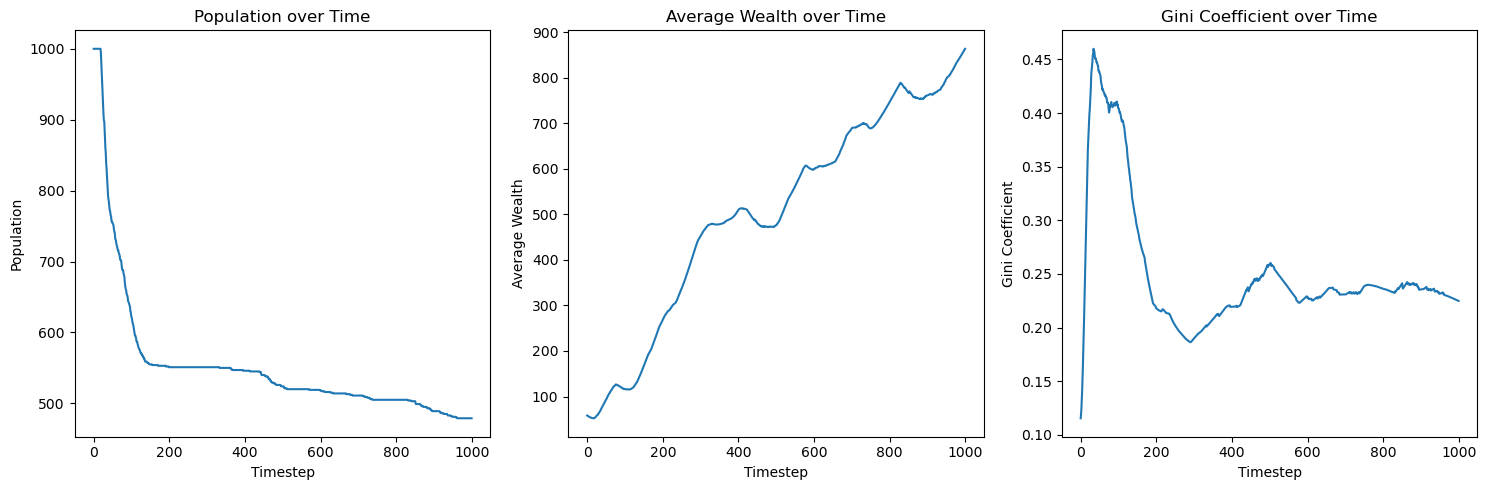

In [7]:
import random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # Import cKDTree for spatial indexing

class SugarscapeEnvironment:
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 show_broadcast_radius=True, show_agent_paths=True, broadcast_radius=5, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.show_broadcast_radius = show_broadcast_radius
        self.show_agent_paths = show_agent_paths
        self.broadcast_radius = broadcast_radius
        self.seed = seed  # Store the seed for reference

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 1,
            'message_expiry': 15,
            'max_relay_messages': 10
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        pygame.init()
        self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
        pygame.display.set_caption("Sugarscape Simulation - With Broadcasting")
        self.clock = pygame.time.Clock()

        self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x, y = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x - center['x']) ** 2 + (y - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': max(1, int(np.random.normal(self.broadcast_radius, self.broadcast_radius / 3))),
            'messages': deque(maxlen=100),
            'destination': None
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        visible_area = self.sugar[max(0, y - vision):min(self.height, y + vision + 1),
                       max(0, x - vision):min(self.width, x + vision + 1)]
        return visible_area

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        # Extract agent positions
        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])

        # Build cKDTree for efficient spatial queries
        tree = cKDTree(positions)

        # Query all neighbors within broadcast_radius for each agent
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Create the message from this agent
            visible_sugar = self.get_visible_sugar(agent).sum()
            message = {
                'sender_id': agent['id'],
                'sugar_amount': visible_sugar,
                'timestep': self.timestep,
                'x': agent['x'],
                'y': agent['y']
            }

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    self.agents[neighbor_idx]['messages'].append(message)

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Check messages for better locations
        best_message = max(agent['messages'], key=lambda m: m['sugar_amount'], default=None)
        if best_message and best_message['sugar_amount'] > self.get_visible_sugar(agent).sum():
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        possible_moves = []
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < self.width and 0 <= new_y < self.height and (new_x, new_y) not in self.agent_positions:
                sugar_amount = self.sugar[new_y, new_x]
                # To optimize, precompute a minimum distance from others
                # Using a generator expression is still costly; consider alternatives if needed
                distance_from_others = min(
                    (abs(new_x - a['x']) + abs(new_y - a['y']) for a in self.agents if a != agent), default=0)
                possible_moves.append((new_x, new_y, sugar_amount, distance_from_others))

        if not possible_moves:
            return  # No valid moves available

        # Add exploration chance
        if random.random() < 0.1:  # 10% chance to make a random move
            new_x, new_y, _, _ = random.choice(possible_moves)
        else:
            if agent['destination']:
                # Move towards the destination
                dest_x, dest_y = agent['destination']
                possible_moves.sort(
                    key=lambda m: abs(m[0] - dest_x) + abs(m[1] - dest_y) - 0.1 * m[3])
            else:
                # Move to the best sugar patch
                possible_moves.sort(key=lambda m: m[2] + 0.1 * m[3], reverse=True)

            # Choose randomly from the top 3 best moves (or all if less than 3)
            best_moves = possible_moves[:min(3, len(possible_moves))]
            new_x, new_y, _, _ = random.choice(best_moves)

        # Update agent position
        self.agent_positions.remove((agent['x'], agent['y']))
        agent['x'], agent['y'] = new_x, new_y
        self.agent_positions.add((new_x, new_y))

        if agent['destination'] and (new_x, new_y) == agent['destination']:
            agent['destination'] = None

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=100)

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def render(self):
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for dead_agent in self.dead_agents:
            pygame.draw.circle(self.screen, (128, 128, 128),
                               (int(dead_agent['x'] * self.cell_size + self.cell_size / 2),
                                int(dead_agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        for agent in self.agents:
            if self.show_broadcast_radius:
                pygame.draw.circle(self.screen, (200, 200, 200),
                                   (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                    int(agent['y'] * self.cell_size + self.cell_size / 2)),
                                   int(agent['broadcast_radius'] * self.cell_size), 1)

            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

            if self.show_agent_paths and agent['destination']:
                pygame.draw.line(self.screen, (0, 255, 0),
                                 (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                  int(agent['y'] * self.cell_size + self.cell_size / 2)),
                                 (int(agent['destination'][0] * self.cell_size + self.cell_size / 2),
                                  int(agent['destination'][1] * self.cell_size + self.cell_size / 2)),
                                 1)

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            self.clock.tick(5)  # Adjust simulation speed as needed

        self.plot_results()
        pygame.quit()

# Example usage with a fixed seed for reproducibility
if __name__ == "__main__":
    SEED = 23  # You can choose any integer value for the seed
    env = SugarscapeEnvironment(width=50, height=50, num_agents=1000, cell_size=10,
                                broadcast_radius=15,
                                show_sugar_levels=False,
                                show_broadcast_radius=False,
                                show_agent_paths=True,
                                seed=SEED)
    env.run_simulation(max_timesteps=1000)


### 1.2.2 - Multiple Runs With No Visualisation

In [4]:
# communicative_model.py

import random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # Import cKDTree for spatial indexing

class SugarscapeEnvironmentCommunicative:
    # Constructor
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Increased broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # if seed not set then choose at random
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        #Parameters for environment dynamics
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 1, 
            'message_expiry': 30,  # Extended message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    #Create sugar peaks at beginning of episode
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    # Creates job_center
    # uses DURATION for lifespan of job_center
    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })


    # Manages sugar regeneration of peaks
    # SUGAR PEAK SPREAD used to determine the size of the job center to regenerate within range of the spread
    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    # POSITIONING of agents in unique locations
    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    # agent constructor
    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': visible_sugar[loc[0], loc[1]],
                    'x': agent['x'] + loc[1] - agent['vision'],
                    'y': agent['y'] + loc[0] - agent['vision']
                }
                messages.append(msg)

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(key=lambda m: (m['sugar_amount'], -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']), -m['timestep']), reverse=True)
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Calculate move that brings agent closer to the destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Function to run multiple simulations and collect averaged results
def run_multiple_simulations_communicative(num_runs=20, width=50, height=50, num_agents=1000,
                                           cell_size=10, broadcast_radius=10, max_timesteps=1000):
    population_histories = []
    average_wealth_histories = []
    gini_coefficient_histories = []

    for run in range(num_runs):
        seed = run  # Different seed for each run
        env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                 cell_size=cell_size, show_sugar_levels=False,
                                                 broadcast_radius=broadcast_radius, seed=seed, visualize=False)
        print(f"Running communicative simulation {run + 1}/{num_runs} with seed {seed}...")
        for _ in range(max_timesteps):
            env.step()
        population_histories.append(env.population_history)
        average_wealth_histories.append(env.average_wealth_history)
        gini_coefficient_histories.append(env.gini_coefficient_history)

    # Convert lists to NumPy arrays for statistical analysis
    population_histories = np.array(population_histories)
    average_wealth_histories = np.array(average_wealth_histories)
    gini_coefficient_histories = np.array(gini_coefficient_histories)

    # Calculate average and standard deviation
    avg_population = np.mean(population_histories, axis=0)
    std_population = np.std(population_histories, axis=0)

    avg_wealth = np.mean(average_wealth_histories, axis=0)
    std_wealth = np.std(average_wealth_histories, axis=0)

    avg_gini = np.mean(gini_coefficient_histories, axis=0)
    std_gini = np.std(gini_coefficient_histories, axis=0)

    # Plot averaged results with standard deviation
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.ylim(bottom=0)
    plt.plot(avg_population, label='Average Population', color='blue')
    plt.fill_between(range(max_timesteps), avg_population - std_population, avg_population + std_population,
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Population over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.legend()

    plt.subplot(132)
    plt.plot(avg_wealth, label='Average Wealth', color='orange')
    plt.fill_between(range(max_timesteps), avg_wealth - std_wealth, avg_wealth + std_wealth,
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Average Wealth over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Average Wealth')
    plt.ylim(bottom=0)

    plt.legend()

    plt.subplot(133)
    plt.plot(avg_gini, label='Average Gini Coefficient', color='green')
    plt.fill_between(range(max_timesteps), avg_gini - std_gini, avg_gini + std_gini,
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Gini Coefficient over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Gini Coefficient')
    plt.ylim(bottom=0)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_population, std_population, avg_wealth, std_wealth, avg_gini, std_gini


if __name__ == "__main__":
    # Run communicative simulations
    print("Starting communicative simulations...")
    communicative_avg_population, communicative_std_population, communicative_avg_wealth, communicative_std_wealth, communicative_avg_gini, communicative_std_gini = run_multiple_simulations_communicative(
        num_runs=20, width=50, height=50, num_agents=1000, cell_size=10, broadcast_radius=10, max_timesteps=1000)


    print("\nCommunicative simulations completed and results saved.")


Starting communicative simulations...
Running communicative simulation 1/20 with seed 0...


KeyboardInterrupt: 

# 2- Varying radii, RL applications

## 2.1 - Relationship between broadcast radius and survival rate

This plot includes the data points and a best-fit regression line, along with the Pearson correlation coefficient and p-value to illustrate the strength and significance of the relationship.

pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html

Running simulations for broadcast radius 1
  Simulation 1/3 with seed 0...
  Simulation 2/3 with seed 1...
  Simulation 3/3 with seed 2...

Running simulations for broadcast radius 5
  Simulation 1/3 with seed 0...
  Simulation 2/3 with seed 1...
  Simulation 3/3 with seed 2...

Running simulations for broadcast radius 30
  Simulation 1/3 with seed 0...
  Simulation 2/3 with seed 1...
  Simulation 3/3 with seed 2...

Running simulations for broadcast radius 50
  Simulation 1/3 with seed 0...
  Simulation 2/3 with seed 1...
  Simulation 3/3 with seed 2...

Running simulations for broadcast radius 100
  Simulation 1/3 with seed 0...
  Simulation 2/3 with seed 1...
  Simulation 3/3 with seed 2...


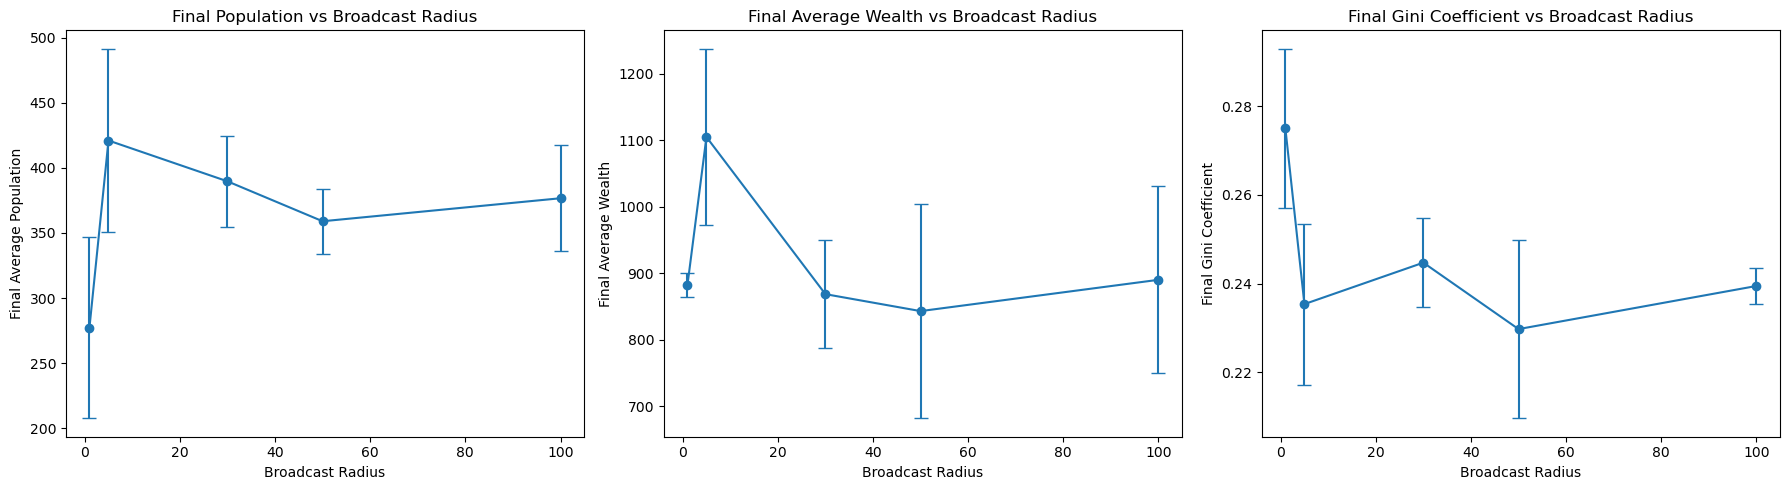

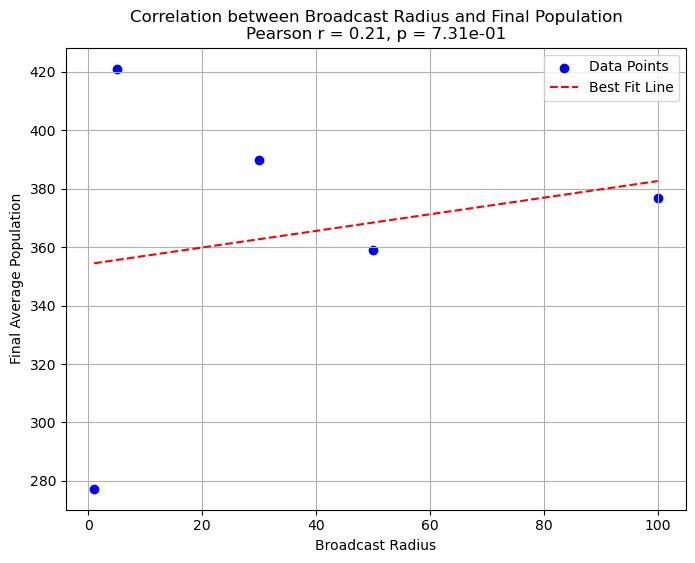


All simulations completed and results saved.


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # For spatial indexing
from scipy.stats import pearsonr  # For correlation calculation
import pickle  # For saving results
# Optional import for visualization (can be ignored if visualize=False)
import pygame

# SugarscapeEnvironmentCommunicative class definition
class SugarscapeEnvironmentCommunicative:
    # Constructor
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # If seed is set, use it for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # Parameters for environment dynamics
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Vision range
            'message_expiry': 30,  # Message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    # Create initial sugar peaks
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    # Create a job center (sugar peak)
    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    # Update sugar landscape based on job centers
    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(
                -distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2)
            )
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    # Initialize agents with unique positions
    def initialize_agents(self):
        agents = []
        available_positions = set(
            (x, y) for x in range(self.width) for y in range(self.height)
        )
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    # Create an agent
    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    # Get adjacent cells for movement
    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [
            (x, y) for x, y in adjacent
            if 0 <= x < self.width and 0 <= y < self.height
        ]

    # Get visible sugar within agent's vision
    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    # Agents broadcast messages about sugar
    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        # For each agent, find neighbors within broadcast radius
        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], agent['broadcast_radius'])
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    # Move agent based on messages or exploration
    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [
            msg for msg in agent['messages']
            if self.timestep - msg['timestep'] <= self.params['message_expiry']
        ]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(
                key=lambda m: (
                    m['sugar_amount'],
                    -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']),
                    -m['timestep']
                ),
                reverse=True
            )
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    # Helper method for moving towards destination
    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Move closer to destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    # Collect sugar and update agent's memory
    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is an integer

    # Perform one simulation step
    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages']
                 if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({
                    'x': agent['x'],
                    'y': agent['y'],
                    'death_time': self.timestep
                })
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents after 5 timesteps
        self.dead_agents = [
            agent for agent in self.dead_agents
            if self.timestep - agent['death_time'] <= 5
        ]

        self.collect_data()
        self.timestep += 1

    # Collect data for analysis
    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    # Calculate Gini coefficient for wealth inequality
    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        n = len(wealth_values)
        total_wealth = cumulative_wealth[-1]
        if total_wealth == 0:
            return 0
        gini = (n + 1 - 2 * np.sum(cumulative_wealth) / total_wealth) / n
        return gini

    # Render the simulation (optional)
    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(
                        x * self.cell_size + self.cell_size // 2,
                        y * self.cell_size + self.cell_size // 2
                    ))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    # Get color based on sugar level
    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    # Run the simulation
    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    # Plot results after simulation
    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Function to run multiple simulations and collect averaged results for varying broadcast radii
def run_multiple_simulations_varying_broadcast_radius(broadcast_radii, num_runs=20, width=50, height=50, num_agents=1000,
                                                      cell_size=10, max_timesteps=1000):
    # Store results for each broadcast radius
    results = []

    for broadcast_radius in broadcast_radii:
        print(f"\nRunning simulations for broadcast radius {broadcast_radius}")
        population_histories = []
        average_wealth_histories = []
        gini_coefficient_histories = []

        for run in range(num_runs):
            seed = run  # Different seed for each run
            env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                     cell_size=cell_size, show_sugar_levels=False,
                                                     broadcast_radius=broadcast_radius, seed=seed, visualize=False)
            print(f"  Simulation {run + 1}/{num_runs} with seed {seed}...")
            for _ in range(max_timesteps):
                env.step()
            population_histories.append(env.population_history)
            average_wealth_histories.append(env.average_wealth_history)
            gini_coefficient_histories.append(env.gini_coefficient_history)

        # Convert lists to NumPy arrays for statistical analysis
        population_histories = np.array(population_histories)
        average_wealth_histories = np.array(average_wealth_histories)
        gini_coefficient_histories = np.array(gini_coefficient_histories)

        # Calculate average and standard deviation
        avg_population = np.mean(population_histories, axis=0)
        std_population = np.std(population_histories, axis=0)

        avg_wealth = np.mean(average_wealth_histories, axis=0)
        std_wealth = np.std(average_wealth_histories, axis=0)

        avg_gini = np.mean(gini_coefficient_histories, axis=0)
        std_gini = np.std(gini_coefficient_histories, axis=0)

        # Store the results
        result = {
            'broadcast_radius': broadcast_radius,
            'avg_population': avg_population,
            'std_population': std_population,
            'avg_wealth': avg_wealth,
            'std_wealth': std_wealth,
            'avg_gini': avg_gini,
            'std_gini': std_gini
        }
        results.append(result)

    return results

# Function to plot results across different broadcast radii
def plot_results_across_broadcast_radii(results, max_timesteps=1000):
    # For each metric, plot the average final value against broadcast radius
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    plt.figure(figsize=(18, 5))

    plt.subplot(131)
    plt.errorbar(broadcast_radii, final_avg_population, yerr=final_std_population, fmt='o-', capsize=5)
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    

    plt.subplot(132)
    plt.errorbar(broadcast_radii, final_avg_wealth, yerr=final_std_wealth, fmt='o-', capsize=5)
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')

    plt.subplot(133)
    plt.errorbar(broadcast_radii, final_avg_gini, yerr=final_std_gini, fmt='o-', capsize=5)
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')

    plt.tight_layout()
    plt.show()

    # Additional plot showing correlation between broadcast radius and survival rate (final population)
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')
    # Fit a linear regression line
    z = np.polyfit(broadcast_radii, final_avg_population, 1)
    p = np.poly1d(z)
    plt.plot(broadcast_radii, p(broadcast_radii), "r--", label='Best Fit Line')
    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Define the set of broadcast radii to test
    # broadcast_radii = [1, 5, 15, 30, 50, 100]
    broadcast_radii = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Run simulations for each broadcast radius
    results = run_multiple_simulations_varying_broadcast_radius(
        broadcast_radii=broadcast_radii,
        num_runs=20,
        width=50,
        height=50,
        num_agents=1000,
        cell_size=10,
        max_timesteps=1000
    )

    # Plot the results
    plot_results_across_broadcast_radii(results)

    # Optionally, save the results to a file for further analysis
    # with open('simulation_results.pkl', 'wb') as f:
    #     pickle.dump(results, f)

    print("\nAll simulations completed and results saved.")


# THIS IS MY STARTING POINT


Running simulations for broadcast radius 0
  Simulation 1/20 with seed 0...
  Simulation 2/20 with seed 1...
  Simulation 3/20 with seed 2...
  Simulation 4/20 with seed 3...
  Simulation 5/20 with seed 4...
  Simulation 6/20 with seed 5...
  Simulation 7/20 with seed 6...
  Simulation 8/20 with seed 7...
  Simulation 9/20 with seed 8...
  Simulation 10/20 with seed 9...
  Simulation 11/20 with seed 10...
  Simulation 12/20 with seed 11...
  Simulation 13/20 with seed 12...
  Simulation 14/20 with seed 13...
  Simulation 15/20 with seed 14...
  Simulation 16/20 with seed 15...
  Simulation 17/20 with seed 16...
  Simulation 18/20 with seed 17...
  Simulation 19/20 with seed 18...
  Simulation 20/20 with seed 19...

Running simulations for broadcast radius 5
  Simulation 1/20 with seed 0...
  Simulation 2/20 with seed 1...
  Simulation 3/20 with seed 2...
  Simulation 4/20 with seed 3...
  Simulation 5/20 with seed 4...
  Simulation 6/20 with seed 5...
  Simulation 7/20 with seed 6...


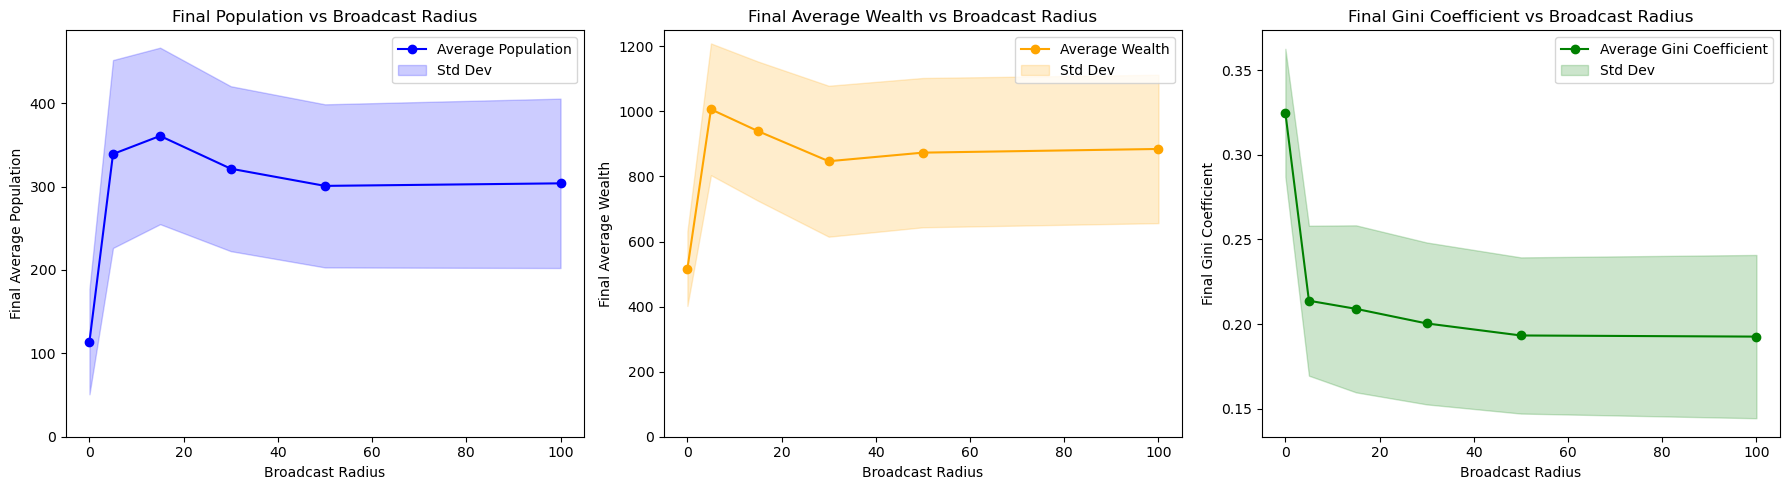

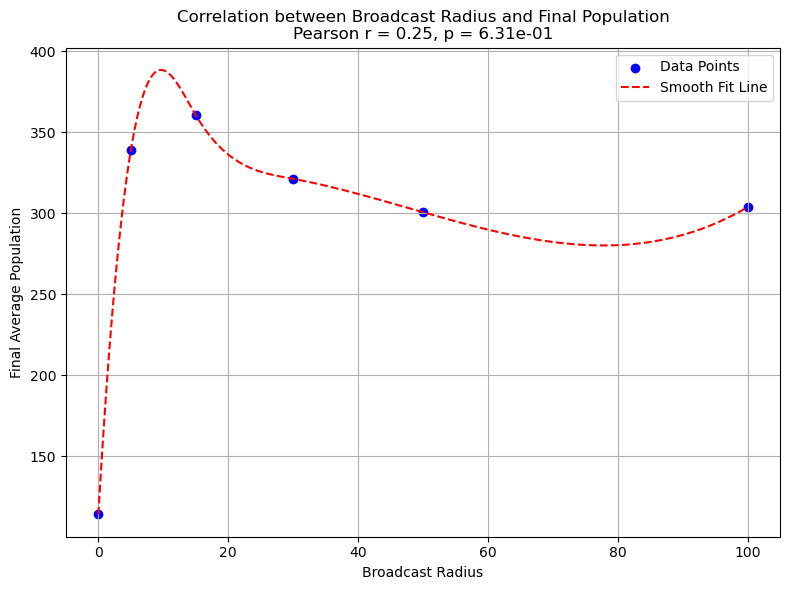


All simulations completed and results saved.


In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # For spatial indexing
from scipy.stats import pearsonr  # For correlation calculation
import pickle  # For saving results
# Optional import for visualization (can be ignored if visualize=False)
import pygame

# SugarscapeEnvironmentCommunicative class definition
class SugarscapeEnvironmentCommunicative:
    # Constructor
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # If seed is set, use it for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # Parameters for environment dynamics
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Vision range
            'message_expiry': 30,  # Message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    # Create initial sugar peaks
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    # Create a job center (sugar peak)
    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    # Update sugar landscape based on job centers
    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(
                -distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2)
            )
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    # Initialize agents with unique positions
    def initialize_agents(self):
        agents = []
        available_positions = set(
            (x, y) for x in range(self.width) for y in range(self.height)
        )
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    # Create an agent
    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    # Get adjacent cells for movement
    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [
            (x, y) for x, y in adjacent
            if 0 <= x < self.width and 0 <= y < self.height
        ]

    # Get visible sugar within agent's vision
    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    # Agents broadcast messages about sugar
    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        # For each agent, find neighbors within broadcast radius
        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], agent['broadcast_radius'])
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    # Move agent based on messages or exploration
    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [
            msg for msg in agent['messages']
            if self.timestep - msg['timestep'] <= self.params['message_expiry']
        ]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(
                key=lambda m: (
                    m['sugar_amount'],
                    -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']),
                    -m['timestep']
                ),
                reverse=True
            )
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    # Helper method for moving towards destination
    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Move closer to destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    # Collect sugar and update agent's memory
    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is an integer

    # Perform one simulation step
    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages']
                 if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({
                    'x': agent['x'],
                    'y': agent['y'],
                    'death_time': self.timestep
                })
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents after 5 timesteps
        self.dead_agents = [
            agent for agent in self.dead_agents
            if self.timestep - agent['death_time'] <= 5
        ]

        self.collect_data()
        self.timestep += 1

    # Collect data for analysis
    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    # Calculate Gini coefficient for wealth inequality
    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        n = len(wealth_values)
        total_wealth = cumulative_wealth[-1]
        if total_wealth == 0:
            return 0
        gini = (n + 1 - 2 * np.sum(cumulative_wealth) / total_wealth) / n
        return gini

    # Render the simulation (optional)
    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(
                        x * self.cell_size + self.cell_size // 2,
                        y * self.cell_size + self.cell_size // 2
                    ))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    # Get color based on sugar level
    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    # Run the simulation
    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    # Plot results after simulation
    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Function to run multiple simulations and collect averaged results for varying broadcast radii
def run_multiple_simulations_varying_broadcast_radius(broadcast_radii, num_runs=20, width=50, height=50, num_agents=1000,
                                                      cell_size=10, max_timesteps=1000):
    # Store results for each broadcast radius
    results = []

    for broadcast_radius in broadcast_radii:
        print(f"\nRunning simulations for broadcast radius {broadcast_radius}")
        population_histories = []
        average_wealth_histories = []
        gini_coefficient_histories = []

        for run in range(num_runs):
            seed = run  # Different seed for each run
            env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                     cell_size=cell_size, show_sugar_levels=False,
                                                     broadcast_radius=broadcast_radius, seed=seed, visualize=False)
            print(f"  Simulation {run + 1}/{num_runs} with seed {seed}...")
            for _ in range(max_timesteps):
                env.step()
            population_histories.append(env.population_history)
            average_wealth_histories.append(env.average_wealth_history)
            gini_coefficient_histories.append(env.gini_coefficient_history)

        # Convert lists to NumPy arrays for statistical analysis
        population_histories = np.array(population_histories)
        average_wealth_histories = np.array(average_wealth_histories)
        gini_coefficient_histories = np.array(gini_coefficient_histories)

        # Calculate average and standard deviation
        avg_population = np.mean(population_histories, axis=0)
        std_population = np.std(population_histories, axis=0)

        avg_wealth = np.mean(average_wealth_histories, axis=0)
        std_wealth = np.std(average_wealth_histories, axis=0)

        avg_gini = np.mean(gini_coefficient_histories, axis=0)
        std_gini = np.std(gini_coefficient_histories, axis=0)

        # Store the results
        result = {
            'broadcast_radius': broadcast_radius,
            'avg_population': avg_population,
            'std_population': std_population,
            'avg_wealth': avg_wealth,
            'std_wealth': std_wealth,
            'avg_gini': avg_gini,
            'std_gini': std_gini
        }
        results.append(result)

    return results

# Function to plot results across different broadcast radii
def plot_results_across_broadcast_radii(results, max_timesteps=1000):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    - max_timesteps (int): Number of timesteps in the simulation.
    """
    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Create a smooth line using spline interpolation if sufficient data points
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        from scipy.interpolate import make_interp_spline
        spline = make_interp_spline(sorted_radii, sorted_population, k=3)  # cubic spline
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Define the set of broadcast radii to test
    # You can adjust these values as needed
    # broadcast_radii = [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
    broadcast_radii = [0, 5, 15, 30, 50,100]

    # Run simulations for each broadcast radius
    # Note: reduced num_runs to 3 for quicker testing
    results = run_multiple_simulations_varying_broadcast_radius(
        broadcast_radii=broadcast_radii,
        num_runs=20,  # set to 20 for experiments
        width=50,
        height=50,
        num_agents=1000,
        cell_size=10,
        max_timesteps=1000
    )

    # Plot the results with updated appearance
    plot_results_across_broadcast_radii(results)

    # Optionally, save the results to a file for further analysis
    with open('simulation_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("\nAll simulations completed and results saved.")


### Parallelizing

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # For spatial indexing
from scipy.stats import pearsonr  # For correlation calculation
import pickle  # For saving results
# Optional import for visualization (can be ignored if visualize=False)
import pygame

# SugarscapeEnvironmentCommunicative class definition
class SugarscapeEnvironmentCommunicative:
    # Constructor
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # If seed is set, use it for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # Parameters for environment dynamics
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Vision range
            'message_expiry': 30,  # Message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=float)  # Changed dtype to float
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()
            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    # Create initial sugar peaks
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    # Create a job center (sugar peak)
    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    # Update sugar landscape based on job centers
    def update_sugar_landscape(self):
        self.sugar.fill(0)  # More efficient than creating a new array
        x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
        for center in self.job_centers:
            distance_squared = (x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2
            exponent = -distance_squared / (2 * self.params['sugar_peak_spread'] ** 2)
            sugar_level = center['max_sugar'] * np.exp(exponent)
            self.sugar += sugar_level
        np.clip(self.sugar, 0, self.params['max_sugar'], out=self.sugar)
        self.sugar = np.round(self.sugar).astype(int)

    # Initialize agents with unique positions
    def initialize_agents(self):
        agents = []
        # Create a list of all positions and shuffle it
        positions = [(x, y) for x in range(self.width) for y in range(self.height)]
        random.shuffle(positions)
        for i in range(min(self.num_agents, len(positions))):
            x, y = positions[i]
            agents.append(self.create_agent(i, x, y))
        return agents

    # Create an agent
    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    # Get adjacent cells for movement
    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [
            (nx, ny) for nx, ny in adjacent
            if 0 <= nx < self.width and 0 <= ny < self.height
        ]

    # Agents broadcast messages about sugar
    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)

        # Precompute messages for all agents
        messages_list = []
        for agent in self.agents:
            # Identify visible sugar peaks
            x, y = agent['x'], agent['y']
            vision = agent['vision']
            y_min = max(0, y - vision)
            y_max = min(self.height, y + vision + 1)
            x_min = max(0, x - vision)
            x_max = min(self.width, x + vision + 1)
            visible_sugar = self.sugar[y_min:y_max, x_min:x_max]

            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = x_min + loc[1]
                msg_y = y_min + loc[0]
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)
            messages_list.append(messages)

        # Broadcast messages
        for i, agent in enumerate(self.agents):
            if not messages_list[i]:
                continue  # No messages to send
            neighbors_idx = tree.query_ball_point([agent['x'], agent['y']], agent['broadcast_radius'])
            for neighbor_idx in neighbors_idx:
                if neighbor_idx != i:
                    neighbor_agent = self.agents[neighbor_idx]
                    neighbor_agent['messages'].extend(messages_list[i])

    # Move agent based on messages or exploration
    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [
            msg for msg in agent['messages']
            if self.timestep - msg['timestep'] <= self.params['message_expiry']
        ]
        if valid_messages:
            # Prioritize messages
            best_message = max(
                valid_messages,
                key=lambda m: (
                    m['sugar_amount'],
                    -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']),
                    -m['timestep']
                )
            )
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    # Helper method for moving towards destination
    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Move closer to destination
            distances = [abs(nx - dest_x) + abs(ny - dest_y) for nx, ny in available_moves]
            min_distance = min(distances)
            closest_moves = [move for move, dist in zip(available_moves, distances) if dist == min_distance]
            chosen_move = random.choice(closest_moves)
        else:
            # Exploration with preference for higher sugar
            if random.random() < self.params['exploration_probability']:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                sugars = [self.sugar[ny, nx] for nx, ny in available_moves]
                max_sugar = max(sugars)
                best_moves = [move for move, sugar in zip(available_moves, sugars) if sugar == max_sugar]
                chosen_move = random.choice(best_moves)

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    # Collect sugar and update agent's memory
    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is an integer

    # Perform one simulation step
    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Broadcast messages before agents move
        self.broadcast_messages()

        # Move agents and collect sugar
        new_agent_positions = set()
        for agent in self.agents:
            self.move_agent(agent)
            self.collect_sugar_and_update_memory(agent)
            new_agent_positions.add((agent['x'], agent['y']))
        self.agent_positions = new_agent_positions

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages']
                 if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({
                    'x': agent['x'],
                    'y': agent['y'],
                    'death_time': self.timestep
                })
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents after 5 timesteps
        self.dead_agents = [
            agent for agent in self.dead_agents
            if self.timestep - agent['death_time'] <= 5
        ]

        self.collect_data()
        self.timestep += 1

    # Collect data for analysis
    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    # Calculate Gini coefficient for wealth inequality
    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = np.array([agent['sugar'] for agent in self.agents])
        sorted_wealth = np.sort(wealth_values)
        n = len(sorted_wealth)
        cumulative_wealth = np.cumsum(sorted_wealth)
        total_wealth = cumulative_wealth[-1]
        if total_wealth == 0:
            return 0
        index = np.arange(1, n + 1)
        gini = (n + 1 - 2 * np.sum((n + 1 - index) * sorted_wealth)) / (n * total_wealth)
        return gini

    # Render the simulation (optional)
    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(
                        x * self.cell_size + self.cell_size // 2,
                        y * self.cell_size + self.cell_size // 2
                    ))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    # Get color based on sugar level
    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    # Run the simulation
    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            if self.visualize:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    # Plot results after simulation
    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Function to run multiple simulations and collect averaged results for varying broadcast radii
def run_multiple_simulations_varying_broadcast_radius(broadcast_radii, num_runs=20, width=50, height=50, num_agents=1000,
                                                      cell_size=10, max_timesteps=1000):
    # Store results for each broadcast radius
    results = []

    for broadcast_radius in broadcast_radii:
        print(f"\nRunning simulations for broadcast radius {broadcast_radius}")
        population_histories = []
        average_wealth_histories = []
        gini_coefficient_histories = []

        for run in range(num_runs):
            seed = run  # Different seed for each run
            env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                     cell_size=cell_size, show_sugar_levels=False,
                                                     broadcast_radius=broadcast_radius, seed=seed, visualize=False)
            print(f"  Simulation {run + 1}/{num_runs} with seed {seed}...")
            for _ in range(max_timesteps):
                env.step()
            population_histories.append(env.population_history)
            average_wealth_histories.append(env.average_wealth_history)
            gini_coefficient_histories.append(env.gini_coefficient_history)

        # Convert lists to NumPy arrays for statistical analysis
        population_histories = np.array(population_histories)
        average_wealth_histories = np.array(average_wealth_histories)
        gini_coefficient_histories = np.array(gini_coefficient_histories)

        # Calculate average and standard deviation
        avg_population = np.mean(population_histories, axis=0)
        std_population = np.std(population_histories, axis=0)

        avg_wealth = np.mean(average_wealth_histories, axis=0)
        std_wealth = np.std(average_wealth_histories, axis=0)

        avg_gini = np.mean(gini_coefficient_histories, axis=0)
        std_gini = np.std(gini_coefficient_histories, axis=0)

        # Store the results
        result = {
            'broadcast_radius': broadcast_radius,
            'avg_population': avg_population,
            'std_population': std_population,
            'avg_wealth': avg_wealth,
            'std_wealth': std_wealth,
            'avg_gini': avg_gini,
            'std_gini': std_gini
        }
        results.append(result)

    return results

# Function to plot results across different broadcast radii
def plot_results_across_broadcast_radii(results, max_timesteps=1000):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    - max_timesteps (int): Number of timesteps in the simulation.
    """
    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Create a smooth line using spline interpolation if sufficient data points
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        from scipy.interpolate import make_interp_spline
        spline = make_interp_spline(sorted_radii, sorted_population, k=3)  # Cubic spline
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Define the set of broadcast radii to test
    broadcast_radii = [0, 5, 15, 30, 50, 100]

    # Run simulations for each broadcast radius
    results = run_multiple_simulations_varying_broadcast_radius(
        broadcast_radii=broadcast_radii,
        num_runs=20,  # Set to 20 for experiments
        width=50,
        height=50,
        num_agents=1000,
        cell_size=10,
        max_timesteps=1000
    )

    # Plot the results with updated appearance
    plot_results_across_broadcast_radii(results)

    # Optionally, save the results to a file for further analysis
    with open('simulation_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("\nAll simulations completed and results saved.")



Running simulations for broadcast radius 0
  Simulation 1/20 with seed 0...


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

### Loading data and plotting (no simulations)

Successfully loaded 5 simulation results from 'simulation_results.pkl'.


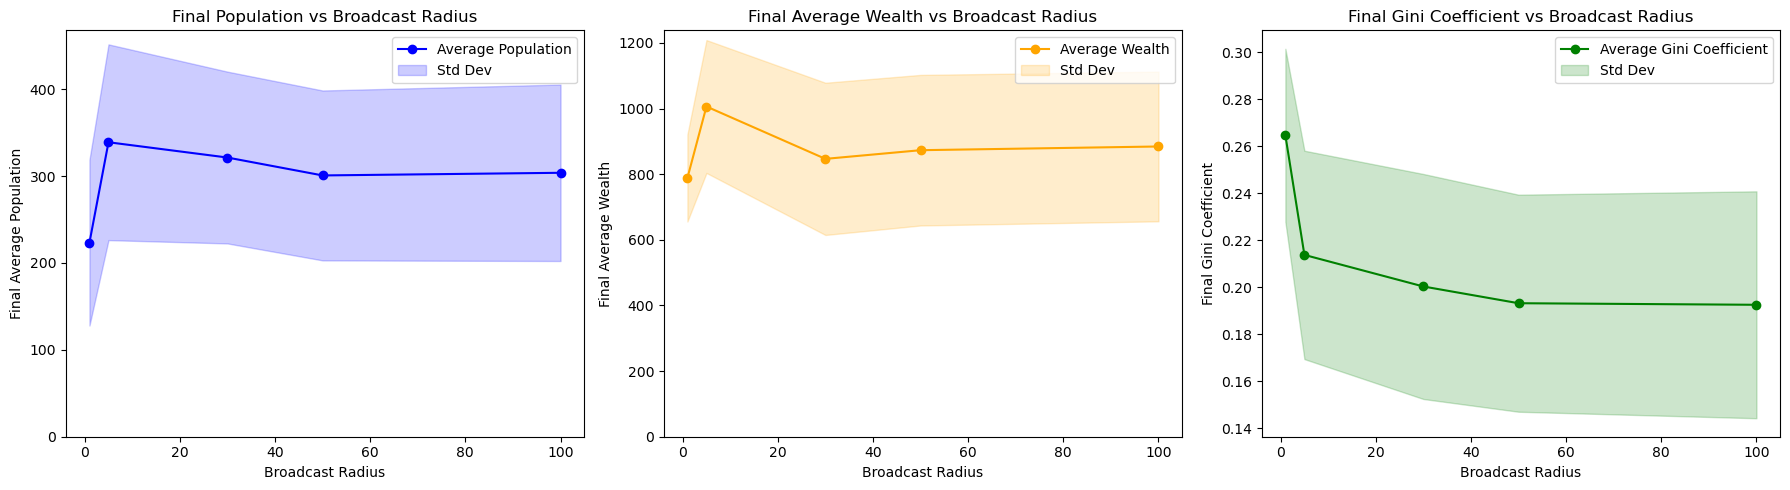

Pearson correlation coefficient between Broadcast Radius and Final Population: 0.23 (p-value: 7.15e-01)


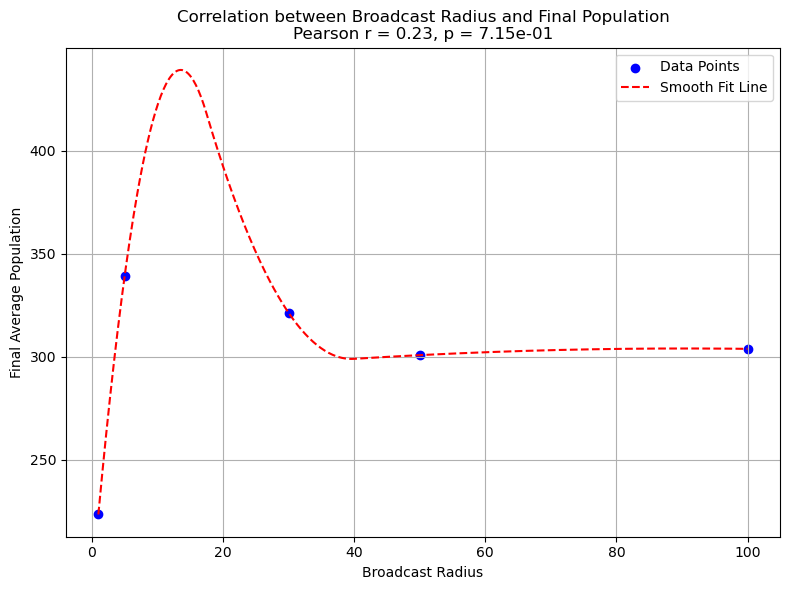

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import make_interp_spline

def load_simulation_results(filepath):
    """
    Load simulation results from a pickle file.

    Parameters:
    - filepath (str): Path to the pickle file containing simulation results.

    Returns:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    try:
        with open(filepath, 'rb') as f:
            results = pickle.load(f)
        print(f"Successfully loaded {len(results)} simulation results from '{filepath}'.")
        return results
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return []
    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return []

def plot_results_across_broadcast_radii(results):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    if not results:
        print("No results to plot.")
        return

    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()
    plt.tight_layout()
    plt.savefig("output-1.jpg")
    plt.show()
    

    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)
    print(f"Pearson correlation coefficient between Broadcast Radius and Final Population: {corr_coef:.2f} (p-value: {p_value:.2e})")

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Check if there are enough points for spline interpolation
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        spline = make_interp_spline(sorted_radii, sorted_population, k=2)  # cubic spline
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("output-2.jpg")
    plt.show()

def main():
    # Path to the results file
    results_filepath = 'simulation_results.pkl'

    # Load the results
    results = load_simulation_results(results_filepath)

    # Plot the results if loading was successful
    if results:
        plot_results_across_broadcast_radii(results)
    else:
        print("No results loaded. Exiting.")

if __name__ == "__main__":
    main()



Running simulations for broadcast radius 0
  Simulation 1/10 with seed 0...
  Simulation 2/10 with seed 1...
  Simulation 3/10 with seed 2...
  Simulation 4/10 with seed 3...
  Simulation 5/10 with seed 4...
  Simulation 6/10 with seed 5...
  Simulation 7/10 with seed 6...
  Simulation 8/10 with seed 7...
  Simulation 9/10 with seed 8...
  Simulation 10/10 with seed 9...

Running simulations for broadcast radius 5
  Simulation 1/10 with seed 0...
  Simulation 2/10 with seed 1...
  Simulation 3/10 with seed 2...
  Simulation 4/10 with seed 3...
  Simulation 5/10 with seed 4...
  Simulation 6/10 with seed 5...
  Simulation 7/10 with seed 6...
  Simulation 8/10 with seed 7...
  Simulation 9/10 with seed 8...
  Simulation 10/10 with seed 9...

Running simulations for broadcast radius 15
  Simulation 1/10 with seed 0...
  Simulation 2/10 with seed 1...
  Simulation 3/10 with seed 2...
  Simulation 4/10 with seed 3...
  Simulation 5/10 with seed 4...
  Simulation 6/10 with seed 5...
  Simul

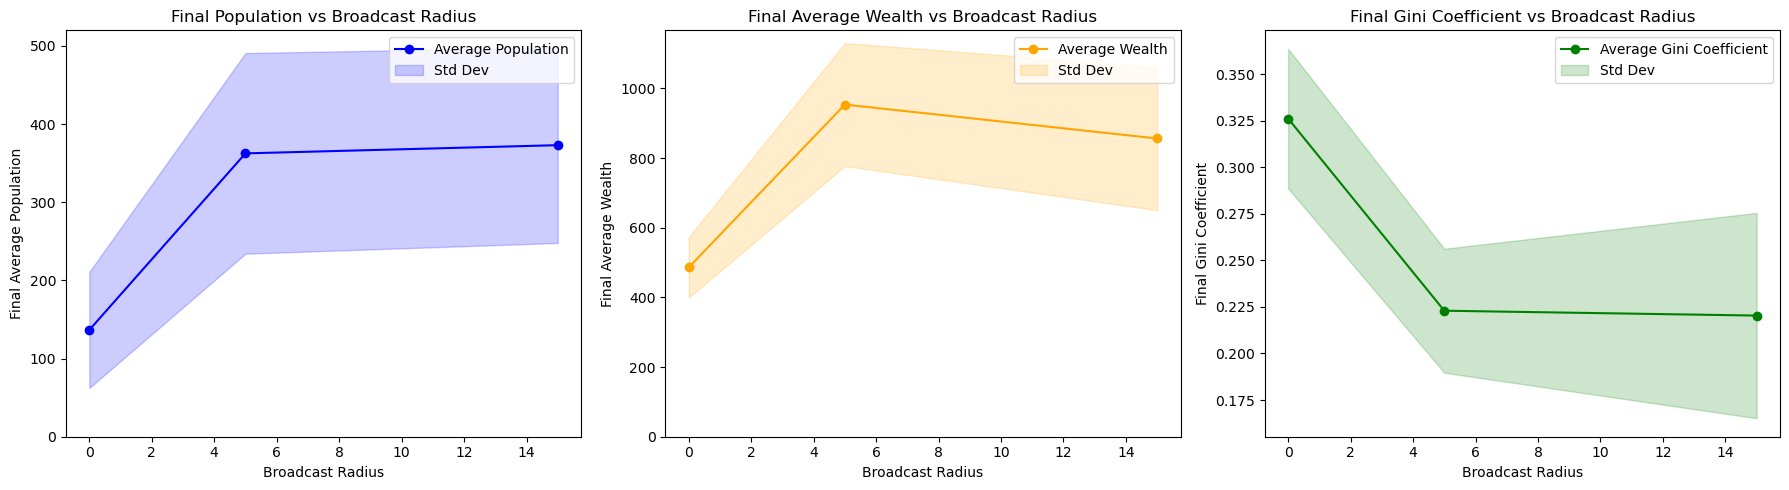

Pearson correlation coefficient between Broadcast Radius and Final Population: 0.78 (p-value: 4.29e-01)


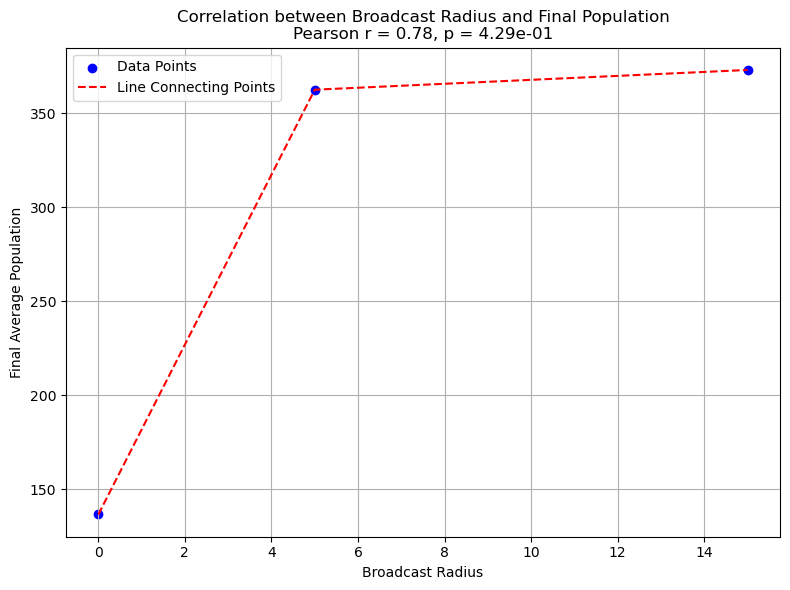


All simulations completed and results saved.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # For spatial indexing
from scipy.stats import pearsonr  # For correlation calculation
from scipy.interpolate import make_interp_spline  # For spline interpolation
import pickle  # For saving results
import pandas as pd  # Import pandas for tabulation
# Optional import for visualization (can be ignored if visualize=False)
import pygame

# SugarscapeEnvironmentCommunicative class definition
class SugarscapeEnvironmentCommunicative:
    # Constructor
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # If seed is set, use it for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # Parameters for environment dynamics
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Vision range
            'message_expiry': 30,  # Message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    # Create initial sugar peaks
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    # Create a job center (sugar peak)
    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    # Update sugar landscape based on job centers
    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(
                -distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2)
            )
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    # Initialize agents with unique positions
    def initialize_agents(self):
        agents = []
        available_positions = set(
            (x, y) for x in range(self.width) for y in range(self.height)
        )
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    # Create an agent
    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    # Get adjacent cells for movement
    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [
            (x, y) for x, y in adjacent
            if 0 <= x < self.width and 0 <= y < self.height
        ]

    # Get visible sugar within agent's vision
    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    # Agents broadcast messages about sugar
    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        # For each agent, find neighbors within broadcast radius
        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], agent['broadcast_radius'])
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    # Move agent based on messages or exploration
    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [
            msg for msg in agent['messages']
            if self.timestep - msg['timestep'] <= self.params['message_expiry']
        ]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(
                key=lambda m: (
                    m['sugar_amount'],
                    -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']),
                    -m['timestep']
                ),
                reverse=True
            )
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    # Helper method for moving towards destination
    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Move closer to destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    # Collect sugar and update agent's memory
    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is an integer

    # Perform one simulation step
    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages']
                 if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({
                    'x': agent['x'],
                    'y': agent['y'],
                    'death_time': self.timestep
                })
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents after 5 timesteps
        self.dead_agents = [
            agent for agent in self.dead_agents
            if self.timestep - agent['death_time'] <= 5
        ]

        self.collect_data()
        self.timestep += 1

    # Collect data for analysis
    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    # Calculate Gini coefficient for wealth inequality
    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        n = len(wealth_values)
        total_wealth = cumulative_wealth[-1]
        if total_wealth == 0:
            return 0
        gini = (n + 1 - 2 * np.sum(cumulative_wealth) / total_wealth) / n
        return gini

    # Render the simulation (optional)
    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(
                        x * self.cell_size + self.cell_size // 2,
                        y * self.cell_size + self.cell_size // 2
                    ))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    # Get color based on sugar level
    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    # Run the simulation
    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    # Plot results after simulation
    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Function to run multiple simulations and collect averaged results for varying broadcast radii
def run_multiple_simulations_varying_broadcast_radius(broadcast_radii, num_runs=20, width=50, height=50, num_agents=1000,
                                                      cell_size=10, max_timesteps=1000):
    """
    Run multiple simulations across different broadcast radii and collect results.
    
    Parameters:
    - broadcast_radii (list): List of broadcast radii to simulate.
    - num_runs (int): Number of runs per broadcast radius.
    - width (int): Width of the grid.
    - height (int): Height of the grid.
    - num_agents (int): Number of agents in the simulation.
    - cell_size (int): Size of each cell for visualization.
    - max_timesteps (int): Number of timesteps per simulation run.
    
    Returns:
    - results (list): List of dictionaries containing averaged results and per-run final metrics for each broadcast radius.
    """
    # Initialize list to store results
    results = []

    for broadcast_radius in broadcast_radii:
        print(f"\nRunning simulations for broadcast radius {broadcast_radius}")
        population_histories = []
        average_wealth_histories = []
        gini_coefficient_histories = []
        
        # Lists to store final metrics per run
        final_populations = []
        final_average_wealths = []
        final_ginis = []

        for run in range(num_runs):
            seed = run  # Different seed for each run
            env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                     cell_size=cell_size, show_sugar_levels=False,
                                                     broadcast_radius=broadcast_radius, seed=seed, visualize=False)
            print(f"  Simulation {run + 1}/{num_runs} with seed {seed}...")
            for _ in range(max_timesteps):
                env.step()
            population_histories.append(env.population_history)
            average_wealth_histories.append(env.average_wealth_history)
            gini_coefficient_histories.append(env.gini_coefficient_history)

            # Extract final metrics
            final_population = env.population_history[-1]
            final_average_wealth = env.average_wealth_history[-1]
            final_gini = env.gini_coefficient_history[-1]

            final_populations.append(final_population)
            final_average_wealths.append(final_average_wealth)
            final_ginis.append(final_gini)

        # Convert lists to NumPy arrays for statistical analysis
        population_histories = np.array(population_histories)
        average_wealth_histories = np.array(average_wealth_histories)
        gini_coefficient_histories = np.array(gini_coefficient_histories)

        # Calculate average and standard deviation
        avg_population = np.mean(population_histories, axis=0)
        std_population = np.std(population_histories, axis=0)

        avg_wealth = np.mean(average_wealth_histories, axis=0)
        std_wealth = np.std(average_wealth_histories, axis=0)

        avg_gini = np.mean(gini_coefficient_histories, axis=0)
        std_gini = np.std(gini_coefficient_histories, axis=0)

        # Calculate additional statistics for final metrics
        population_median = np.median(final_populations)
        population_min = np.min(final_populations)
        population_max = np.max(final_populations)
        population_q1 = np.percentile(final_populations, 25)
        population_q3 = np.percentile(final_populations, 75)

        wealth_median = np.median(final_average_wealths)
        wealth_min = np.min(final_average_wealths)
        wealth_max = np.max(final_average_wealths)
        wealth_q1 = np.percentile(final_average_wealths, 25)
        wealth_q3 = np.percentile(final_average_wealths, 75)

        gini_median = np.median(final_ginis)
        gini_min = np.min(final_ginis)
        gini_max = np.max(final_ginis)
        gini_q1 = np.percentile(final_ginis, 25)
        gini_q3 = np.percentile(final_ginis, 75)

        # Store the results
        result = {
            'broadcast_radius': broadcast_radius,
            'avg_population': avg_population,
            'std_population': std_population,
            'avg_wealth': avg_wealth,
            'std_wealth': std_wealth,
            'avg_gini': avg_gini,
            'std_gini': std_gini,
            # Additional stats
            'final_populations': final_populations,
            'final_average_wealths': final_average_wealths,
            'final_ginis': final_ginis,
            'population_median': population_median,
            'population_min': population_min,
            'population_max': population_max,
            'population_q1': population_q1,
            'population_q3': population_q3,
            'wealth_median': wealth_median,
            'wealth_min': wealth_min,
            'wealth_max': wealth_max,
            'wealth_q1': wealth_q1,
            'wealth_q3': wealth_q3,
            'gini_median': gini_median,
            'gini_min': gini_min,
            'gini_max': gini_max,
            'gini_q1': gini_q1,
            'gini_q3': gini_q3
        }
        results.append(result)

    return results

# Function to plot results across different broadcast radii
def plot_results_across_broadcast_radii(results):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations,
    and generate a comprehensive statistical table saved as a CSV file.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    if not results:
        print("No results to plot.")
        return

    # Initialize lists to store data for tabulation
    table_data = []

    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    # Collect additional statistics
    for res in results:
        table_entry = {
            'Broadcast Radius': res['broadcast_radius'],
            # Population stats
            'Population Mean': np.mean(res['final_populations']),
            'Population Median': res['population_median'],
            'Population Std Dev': np.std(res['final_populations']),
            'Population Min': res['population_min'],
            'Population Q1': res['population_q1'],
            'Population Q3': res['population_q3'],
            'Population Max': res['population_max'],
            # Average Wealth stats
            'Average Wealth Mean': np.mean(res['final_average_wealths']),
            'Average Wealth Median': res['wealth_median'],
            'Average Wealth Std Dev': np.std(res['final_average_wealths']),
            'Average Wealth Min': res['wealth_min'],
            'Average Wealth Q1': res['wealth_q1'],
            'Average Wealth Q3': res['wealth_q3'],
            'Average Wealth Max': res['wealth_max'],
            # Gini Coefficient stats
            'Gini Coefficient Mean': np.mean(res['final_ginis']),
            'Gini Coefficient Median': res['gini_median'],
            'Gini Coefficient Std Dev': np.std(res['final_ginis']),
            'Gini Coefficient Min': res['gini_min'],
            'Gini Coefficient Q1': res['gini_q1'],
            'Gini Coefficient Q3': res['gini_q3'],
            'Gini Coefficient Max': res['gini_max'],
        }
        table_data.append(table_entry)

    # Create a pandas DataFrame
    df = pd.DataFrame(table_data)

    # Save the DataFrame to a CSV file
    df.to_csv('simulation_statistics.csv', index=False)
    print("\nSimulation statistics saved to 'simulation_statistics.csv'.")

    # Print the DataFrame in a tabular format
    print("\nSimulation Statistics:")
    print(df.to_string(index=False))

    # Now, proceed with the existing plotting code

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()
    plt.tight_layout()
    plt.savefig("output-1.jpg")
    plt.show()


    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)
    print(f"Pearson correlation coefficient between Broadcast Radius and Final Population: {corr_coef:.2f} (p-value: {p_value:.2e})")

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Check if there are enough points for spline interpolation
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        spline = make_interp_spline(sorted_radii, sorted_population, k=2)  # quadratic spline for small data
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("output-2.jpg")
    plt.show()

def main():
    # Define the set of broadcast radii to test
    # You can adjust these values as needed
    broadcast_radii = [0, 5, 15]

    # Run simulations for each broadcast radius
    # Note: reduced num_runs to 10 for quicker testing; set to 20 for experiments
    results = run_multiple_simulations_varying_broadcast_radius(
        broadcast_radii=broadcast_radii,
        num_runs=10,  # set to 20 for experiments
        width=50,
        height=50,
        num_agents=1000,
        cell_size=10,
        max_timesteps=1000
    )

    # Plot the results with updated appearance and generate statistical table
    plot_results_across_broadcast_radii(results)

    # Optionally, save the results to a file for further analysis
    with open('simulation_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("\nAll simulations completed and results saved.")

if __name__ == "__main__":
    main()


## Load dataset and plot metrics of v1.0

Successfully loaded 3 simulation results from 'simulation_results.pkl'.

Simulation statistics saved to 'simulation_statistics.csv'.

Simulation Statistics:
 Broadcast Radius  Population Mean  Population Median  Population Std Dev  Population Min  Population Q1  Population Q3  Population Max  Average Wealth Mean  Average Wealth Median  Average Wealth Std Dev  Average Wealth Min  Average Wealth Q1  Average Wealth Q3  Average Wealth Max  Gini Coefficient Mean  Gini Coefficient Median  Gini Coefficient Std Dev  Gini Coefficient Min  Gini Coefficient Q1  Gini Coefficient Q3  Gini Coefficient Max
                0            136.6              152.5           74.255236              20          64.75         193.00             249           486.297952             451.883070               86.577715          399.927184         425.284178         516.421241          644.947826               0.326165                 0.310139                  0.037499              0.281815             0.295489   

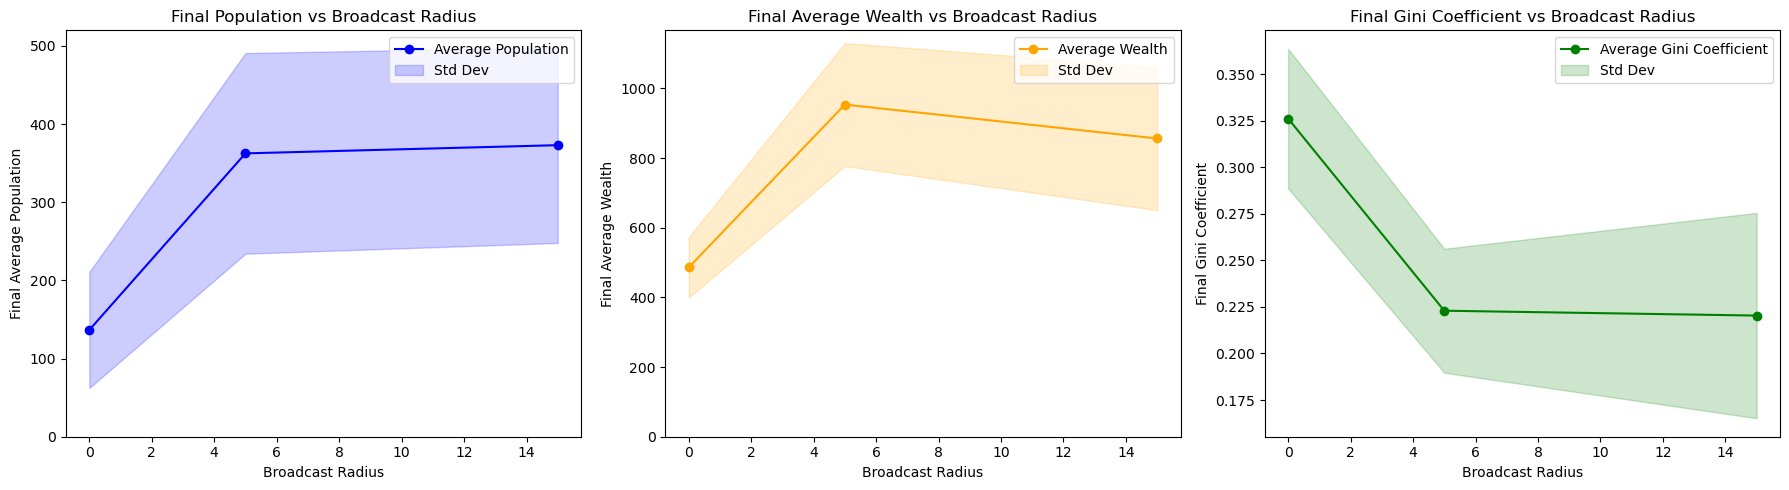

Pearson correlation coefficient between Broadcast Radius and Final Population: 0.78 (p-value: 4.29e-01)


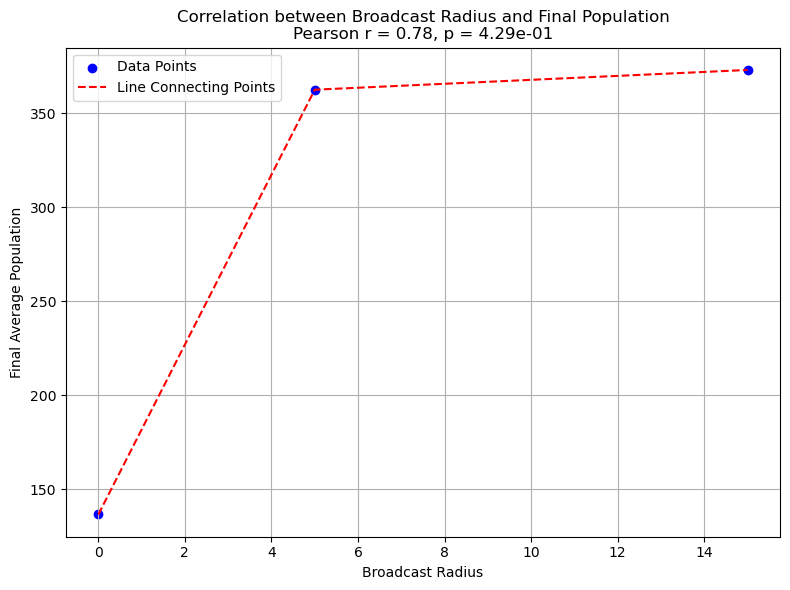

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import make_interp_spline
import pandas as pd  # Import pandas for tabulation

def load_simulation_results(filepath):
    """
    Load simulation results from a pickle file.

    Parameters:
    - filepath (str): Path to the pickle file containing simulation results.

    Returns:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    try:
        with open(filepath, 'rb') as f:
            results = pickle.load(f)
        print(f"Successfully loaded {len(results)} simulation results from '{filepath}'.")
        return results
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return []
    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return []

def plot_results_across_broadcast_radii(results):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations,
    and generate a comprehensive statistical table saved as a CSV file.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    if not results:
        print("No results to plot.")
        return

    # Initialize lists to store data for tabulation
    table_data = []

    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    # Collect additional statistics
    for res in results:
        table_entry = {
            'Broadcast Radius': res['broadcast_radius'],
            # Population stats
            'Population Mean': np.mean(res['final_populations']),
            'Population Median': res['population_median'],
            'Population Std Dev': np.std(res['final_populations']),
            'Population Min': res['population_min'],
            'Population Q1': res['population_q1'],
            'Population Q3': res['population_q3'],
            'Population Max': res['population_max'],
            # Average Wealth stats
            'Average Wealth Mean': np.mean(res['final_average_wealths']),
            'Average Wealth Median': res['wealth_median'],
            'Average Wealth Std Dev': np.std(res['final_average_wealths']),
            'Average Wealth Min': res['wealth_min'],
            'Average Wealth Q1': res['wealth_q1'],
            'Average Wealth Q3': res['wealth_q3'],
            'Average Wealth Max': res['wealth_max'],
            # Gini Coefficient stats
            'Gini Coefficient Mean': np.mean(res['final_ginis']),
            'Gini Coefficient Median': res['gini_median'],
            'Gini Coefficient Std Dev': np.std(res['final_ginis']),
            'Gini Coefficient Min': res['gini_min'],
            'Gini Coefficient Q1': res['gini_q1'],
            'Gini Coefficient Q3': res['gini_q3'],
            'Gini Coefficient Max': res['gini_max'],
        }
        table_data.append(table_entry)

    # Create a pandas DataFrame
    df = pd.DataFrame(table_data)

    # Save the DataFrame to a CSV file
    df.to_csv('simulation_statistics.csv', index=False)
    print("\nSimulation statistics saved to 'simulation_statistics.csv'.")

    # Print the DataFrame in a tabular format
    print("\nSimulation Statistics:")
    print(df.to_string(index=False))

    # Now, proceed with the existing plotting code

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()
    plt.tight_layout()
    plt.savefig("output-1.jpg")
    plt.show()


    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)
    print(f"Pearson correlation coefficient between Broadcast Radius and Final Population: {corr_coef:.2f} (p-value: {p_value:.2e})")

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Check if there are enough points for spline interpolation
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        spline = make_interp_spline(sorted_radii, sorted_population, k=2)  # quadratic spline for small data
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("output-2.jpg")
    plt.show()

def main():
    # Path to the results file
    results_filepath = 'simulation_results.pkl'

    # Load the results
    results = load_simulation_results(results_filepath)

    # Plot the results if loading was successful
    if results:
        plot_results_across_broadcast_radii(results)
    else:
        print("No results loaded. Exiting.")

if __name__ == "__main__":
    main()


# 2- Rural vs Urban

## Visual Debugger

## Just for loading data and displaying:

Successfully loaded 5 simulation results from 'simulation_results1.pkl'.


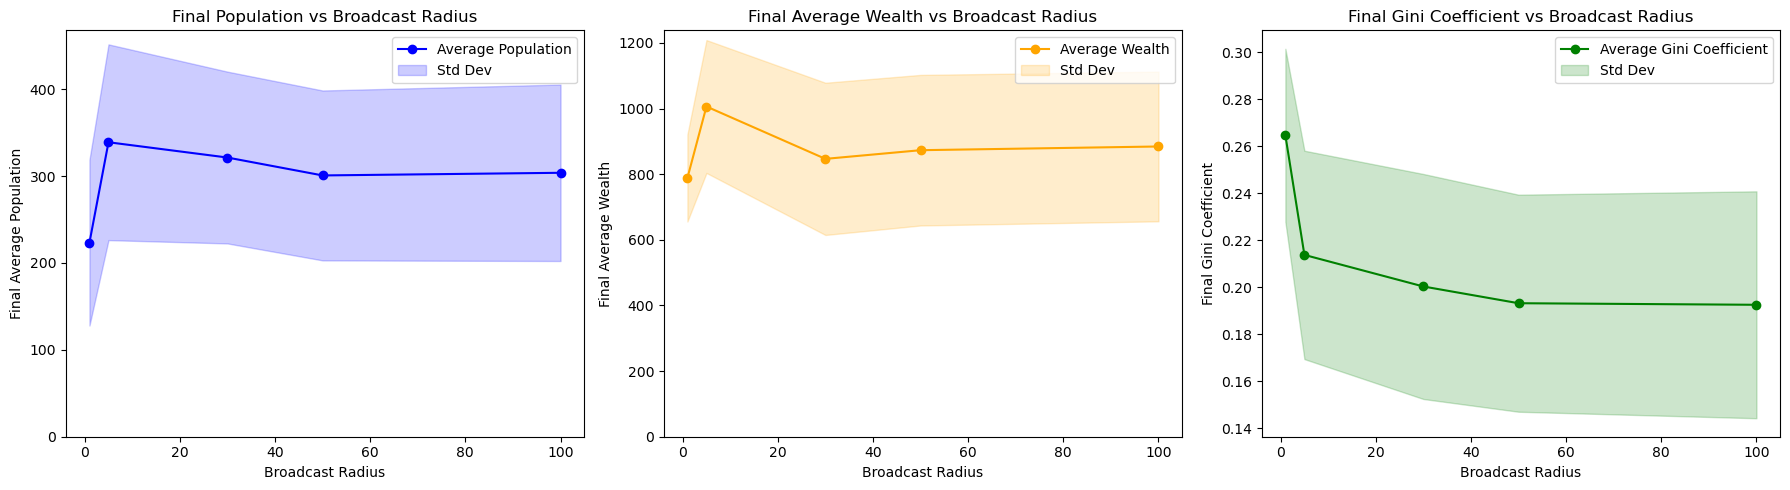

Pearson correlation coefficient between Broadcast Radius and Final Population: 0.23 (p-value: 7.15e-01)


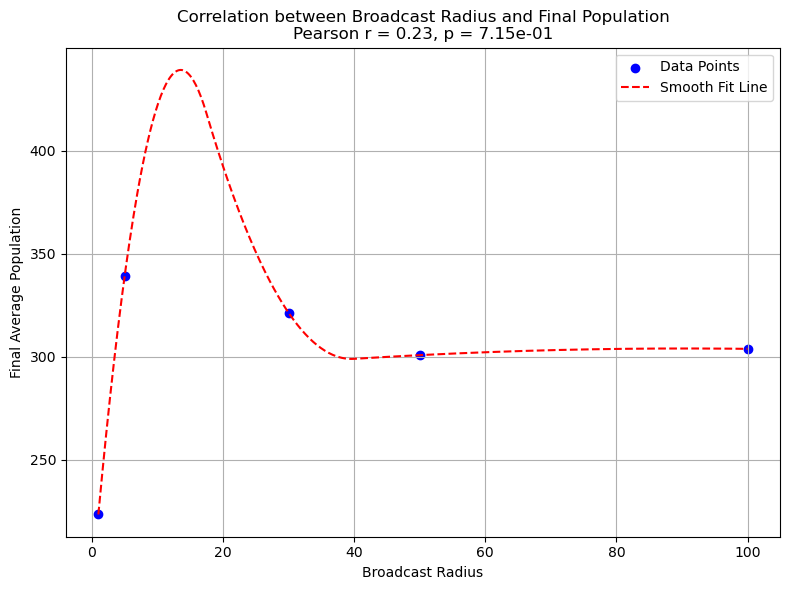

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import make_interp_spline

def load_simulation_results(filepath):
    """
    Load simulation results from a pickle file.

    Parameters:
    - filepath (str): Path to the pickle file containing simulation results.

    Returns:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    try:
        with open(filepath, 'rb') as f:
            results = pickle.load(f)
        print(f"Successfully loaded {len(results)} simulation results from '{filepath}'.")
        return results
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return []
    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return []

def plot_results_across_broadcast_radii(results):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    """
    if not results:
        print("No results to plot.")
        return

    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'][-1] for res in results]
    final_std_population = [res['std_population'][-1] for res in results]

    final_avg_wealth = [res['avg_wealth'][-1] for res in results]
    final_std_wealth = [res['std_wealth'][-1] for res in results]

    final_avg_gini = [res['avg_gini'][-1] for res in results]
    final_std_gini = [res['std_gini'][-1] for res in results]

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()
    plt.tight_layout()
    plt.savefig("output-1.jpg")
    plt.show()
    

    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)
    print(f"Pearson correlation coefficient between Broadcast Radius and Final Population: {corr_coef:.2f} (p-value: {p_value:.2e})")

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Check if there are enough points for spline interpolation
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        spline = make_interp_spline(sorted_radii, sorted_population, k=2)  # cubic spline
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("output-2.jpg")
    plt.show()

def main():
    # Path to the results file
    results_filepath = 'simulation_results1.pkl'

    # Load the results
    results = load_simulation_results(results_filepath)

    # Plot the results if loading was successful
    if results:
        plot_results_across_broadcast_radii(results)
    else:
        print("No results loaded. Exiting.")

if __name__ == "__main__":
    main()

# Version 2???

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # For spatial indexing
from scipy.stats import pearsonr  # For correlation calculation
import pickle  # For saving results
import csv  # For saving data to CSV files
# Optional import for visualization (can be ignored if visualize=False)
import pygame

# SugarscapeEnvironmentCommunicative class definition
class SugarscapeEnvironmentCommunicative:
    # Constructor
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # If seed is set, use it for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # Parameters for environment dynamics
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Vision range
            'message_expiry': 30,  # Message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.average_network_size_history = []  # For average network size per timestep
        self.timestep = 0

    # Create initial sugar peaks
    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    # Create a job center (sugar peak)
    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    # Update sugar landscape based on job centers
    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(
                -distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2)
            )
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    # Initialize agents with unique positions
    def initialize_agents(self):
        agents = []
        available_positions = set(
            (x, y) for x in range(self.width) for y in range(self.height)
        )
        for i in range(self.num_agents):
            if not available_positions:
                break
            position = random.choice(tuple(available_positions))
            available_positions.remove(position)
            x, y = position
            agents.append(self.create_agent(i, x, y))
        return agents

    # Create an agent
    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    # Get adjacent cells for movement
    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [
            (x, y) for x, y in adjacent
            if 0 <= x < self.width and 0 <= y < self.height
        ]

    # Get visible sugar within agent's vision
    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    # Agents broadcast messages about sugar
    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        network_sizes = []

        # For each agent, find neighbors within broadcast radius
        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], agent['broadcast_radius'])
            network_size = len(neighbors) - 1  # Exclude the agent itself
            network_sizes.append(network_size)

            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

        # Calculate average network size for this timestep
        if network_sizes:
            average_network_size = sum(network_sizes) / len(network_sizes)
        else:
            average_network_size = 0
        self.average_network_size_history.append(average_network_size)

    # Move agent based on messages or exploration
    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [
            msg for msg in agent['messages']
            if self.timestep - msg['timestep'] <= self.params['message_expiry']
        ]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(
                key=lambda m: (
                    m['sugar_amount'],
                    -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']),
                    -m['timestep']
                ),
                reverse=True
            )
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    # Helper method for moving towards destination
    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Move closer to destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    # Collect sugar and update agent's memory
    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is an integer

    # Perform one simulation step
    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages and collect network size data
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages']
                 if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({
                    'x': agent['x'],
                    'y': agent['y'],
                    'death_time': self.timestep
                })
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Remove dead agents after 5 timesteps
        self.dead_agents = [
            agent for agent in self.dead_agents
            if self.timestep - agent['death_time'] <= 5
        ]

        self.collect_data()
        self.timestep += 1

    # Collect data for analysis
    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())
        # Average network size is already collected in broadcast_messages()

    # Calculate Gini coefficient for wealth inequality
    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        n = len(wealth_values)
        total_wealth = cumulative_wealth[-1]
        if total_wealth == 0:
            return 0
        gini = (n + 1 - 2 * np.sum(cumulative_wealth) / total_wealth) / n
        return gini

    # Render the simulation (optional)
    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(
                        x * self.cell_size + self.cell_size // 2,
                        y * self.cell_size + self.cell_size // 2
                    ))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    # Get color based on sugar level
    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    # Run the simulation
    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    # Plot results after simulation
    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

# Function to run multiple simulations and collect averaged results for varying broadcast radii
def run_multiple_simulations_varying_broadcast_radius(broadcast_radii, num_runs=20, width=50, height=50, num_agents=1000,
                                                      cell_size=10, max_timesteps=1000):
    # Store results for each broadcast radius
    results = []

    for broadcast_radius in broadcast_radii:
        print(f"\nRunning simulations for broadcast radius {broadcast_radius}")
        population_histories = []
        average_wealth_histories = []
        gini_coefficient_histories = []
        average_network_size_histories = []
        population_histories_full = []  # For plotting population vs timestep

        for run in range(num_runs):
            seed = run  # Different seed for each run
            env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                     cell_size=cell_size, show_sugar_levels=False,
                                                     broadcast_radius=broadcast_radius, seed=seed, visualize=False)
            print(f"  Simulation {run + 1}/{num_runs} with seed {seed}...")
            for _ in range(max_timesteps):
                env.step()
            population_histories.append(env.population_history[-1])  # Final population
            average_wealth_histories.append(env.average_wealth_history[-1])  # Final average wealth
            gini_coefficient_histories.append(env.gini_coefficient_history[-1])  # Final Gini coefficient
            average_network_size_histories.append(np.mean(env.average_network_size_history))
            population_histories_full.append(env.population_history)  # Full population history

        # Convert lists to NumPy arrays for statistical analysis
        population_histories = np.array(population_histories)
        average_wealth_histories = np.array(average_wealth_histories)
        gini_coefficient_histories = np.array(gini_coefficient_histories)
        average_network_size_histories = np.array(average_network_size_histories)
        population_histories_full = np.array(population_histories_full)

        # Calculate average and standard deviation
        avg_population = np.mean(population_histories)
        std_population = np.std(population_histories)

        avg_wealth = np.mean(average_wealth_histories)
        std_wealth = np.std(average_wealth_histories)

        avg_gini = np.mean(gini_coefficient_histories)
        std_gini = np.std(gini_coefficient_histories)

        avg_network_size = np.mean(average_network_size_histories)
        std_network_size = np.std(average_network_size_histories)

        avg_population_history = np.mean(population_histories_full, axis=0)

        # Store the results
        result = {
            'broadcast_radius': broadcast_radius,
            'avg_population': avg_population,
            'std_population': std_population,
            'avg_wealth': avg_wealth,
            'std_wealth': std_wealth,
            'avg_gini': avg_gini,
            'std_gini': std_gini,
            'avg_network_size': avg_network_size,
            'std_network_size': std_network_size,
            'avg_population_history': avg_population_history  # For plotting population vs timestep
        }
        results.append(result)

    return results

# Function to plot results across different broadcast radii
def plot_results_across_broadcast_radii(results, max_timesteps=1000):
    """
    Plot the specified metrics across different broadcast radii using mean values and shaded areas for deviations.

    Parameters:
    - results (list): List of dictionaries with simulation results for each broadcast radius.
    - max_timesteps (int): Number of timesteps in the simulation.
    """
    # Extract broadcast radii and corresponding final metrics
    broadcast_radii = [res['broadcast_radius'] for res in results]
    final_avg_population = [res['avg_population'] for res in results]
    final_std_population = [res['std_population'] for res in results]

    final_avg_wealth = [res['avg_wealth'] for res in results]
    final_std_wealth = [res['std_wealth'] for res in results]

    final_avg_gini = [res['avg_gini'] for res in results]
    final_std_gini = [res['std_gini'] for res in results]

    avg_network_sizes = [res['avg_network_size'] for res in results]
    std_network_sizes = [res['std_network_size'] for res in results]

    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Final Population vs Broadcast Radius
    plt.subplot(131)
    plt.plot(broadcast_radii, final_avg_population, label='Average Population', color='blue', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_population) - np.array(final_std_population),
                     np.array(final_avg_population) + np.array(final_std_population),
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Final Population vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 2: Final Average Wealth vs Broadcast Radius
    plt.subplot(132)
    plt.plot(broadcast_radii, final_avg_wealth, label='Average Wealth', color='orange', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_wealth) - np.array(final_std_wealth),
                     np.array(final_avg_wealth) + np.array(final_std_wealth),
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Final Average Wealth vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Wealth')
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend()

    # Subplot 3: Final Gini Coefficient vs Broadcast Radius
    plt.subplot(133)
    plt.plot(broadcast_radii, final_avg_gini, label='Average Gini Coefficient', color='green', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(final_avg_gini) - np.array(final_std_gini),
                     np.array(final_avg_gini) + np.array(final_std_gini),
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Final Gini Coefficient vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Additional plot showing correlation between broadcast radius and final population
    # Compute Pearson correlation coefficient
    corr_coef, p_value = pearsonr(broadcast_radii, final_avg_population)

    # Create a new figure for the correlation plot
    plt.figure(figsize=(8, 6))
    plt.scatter(broadcast_radii, final_avg_population, color='blue', label='Data Points')

    # Create a smooth line using spline interpolation if sufficient data points
    if len(broadcast_radii) >= 4:
        # Sort the data for proper spline fitting
        sorted_indices = np.argsort(broadcast_radii)
        sorted_radii = np.array(broadcast_radii)[sorted_indices]
        sorted_population = np.array(final_avg_population)[sorted_indices]

        # Perform spline interpolation
        from scipy.interpolate import make_interp_spline
        spline = make_interp_spline(sorted_radii, sorted_population, k=3)  # cubic spline
        radii_smooth = np.linspace(sorted_radii.min(), sorted_radii.max(), 500)
        population_smooth = spline(radii_smooth)
        plt.plot(radii_smooth, population_smooth, "r--", label='Smooth Fit Line')
    else:
        # If too few points for spline, just connect them with lines
        plt.plot(broadcast_radii, final_avg_population, "r--", label='Line Connecting Points')

    plt.title(f'Correlation between Broadcast Radius and Final Population\n'
              f'Pearson r = {corr_coef:.2f}, p = {p_value:.2e}')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Final Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Population vs Timestep for each Broadcast Radius
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
    for idx, res in enumerate(results):
        plt.plot(res['avg_population_history'], label=f"Broadcast Radius {res['broadcast_radius']}",
                 color=colors[idx])
    plt.title('Population over Time for Different Broadcast Radii')
    plt.xlabel('Timestep')
    plt.ylabel('Average Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Average Network Size vs Broadcast Radius
    plt.figure(figsize=(8, 6))
    plt.plot(broadcast_radii, avg_network_sizes, label='Average Network Size', color='purple', marker='o')
    plt.fill_between(broadcast_radii,
                     np.array(avg_network_sizes) - np.array(std_network_sizes),
                     np.array(avg_network_sizes) + np.array(std_network_sizes),
                     color='purple', alpha=0.2, label='Std Dev')
    plt.title('Average Network Size vs Broadcast Radius')
    plt.xlabel('Broadcast Radius')
    plt.ylabel('Average Network Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save data to CSV files
    # Save average network size data
    with open('average_network_size_data.csv', 'w', newline='') as csvfile:
        fieldnames = ['Broadcast Radius', 'Average Network Size', 'Std Dev']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for res in results:
            writer.writerow({
                'Broadcast Radius': res['broadcast_radius'],
                'Average Network Size': res['avg_network_size'],
                'Std Dev': res['std_network_size']
            })

    # Save population over time data
    with open('population_over_time_data.csv', 'w', newline='') as csvfile:
        fieldnames = ['Timestep'] + [f"BR_{res['broadcast_radius']}" for res in results]
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)
        max_timesteps = len(results[0]['avg_population_history'])
        for t in range(max_timesteps):
            row = [t] + [res['avg_population_history'][t] for res in results]
            writer.writerow(row)

    # Save final metrics data
    with open('final_metrics_data.csv', 'w', newline='') as csvfile:
        fieldnames = ['Broadcast Radius', 'Final Average Population', 'Std Dev Population',
                      'Final Average Wealth', 'Std Dev Wealth',
                      'Final Gini Coefficient', 'Std Dev Gini']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for res in results:
            writer.writerow({
                'Broadcast Radius': res['broadcast_radius'],
                'Final Average Population': res['avg_population'],
                'Std Dev Population': res['std_population'],
                'Final Average Wealth': res['avg_wealth'],
                'Std Dev Wealth': res['std_wealth'],
                'Final Gini Coefficient': res['avg_gini'],
                'Std Dev Gini': res['std_gini']
            })

if __name__ == "__main__":
    # Define the set of broadcast radii to test
    broadcast_radii = [0, 10, 15, 20, 30, 40, 50, 60, 70]

    # Run simulations for each broadcast radius
    # Note: set num_runs to 20 for experiments
    results = run_multiple_simulations_varying_broadcast_radius(
        broadcast_radii=broadcast_radii,
        num_runs=20,  # Set to 20 for experiments
        width=50,
        height=50,
        num_agents=1000,
        cell_size=10,
        max_timesteps=1000
    )

    # Plot the results with updated appearance
    plot_results_across_broadcast_radii(results)

    # Optionally, save the results to a file for further analysis
    with open('simulation_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("\nAll simulations completed and results saved.")



Running simulations for broadcast radius 0
  Simulation 1/20 with seed 0...


KeyboardInterrupt: 